# Crunchbase 
In this notebook I will work with data from crunchbase dataset and check few hypotheses.

Data in crunchbase dataset is changing daily. To avoid any discrepancies in results, I will use data fixed on 09.09.2020

##1. Data preprocessing

####1.1 Import the required libraries


In [ ]:
!pip install plot-metric

In [ ]:
import math
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score 
from sklearn.metrics import auc 
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from plot_metric.functions import BinaryClassification


####1.2 Move the archived data from the cloud to the current folder and unzip it

In [ ]:
!cp drive/My\ Drive/bulk_export.tar.gz .


In [ ]:
!tar -zxvf bulk_export.tar.gz

category_groups.csv
funds.csv
org_parents.csv
events.csv
ipos.csv
investment_partners.csv
acquisitions.csv
investors.csv
degrees.csv
funding_rounds.csv
event_appearances.csv
people_descriptions.csv
investments.csv
organization_descriptions.csv
people.csv
jobs.csv
organizations.csv
checksum.csv


####1.3 Read csv tables


In [ ]:
category_groups           = pd.read_csv('category_groups.csv')
funds                     = pd.read_csv('funds.csv')
org_parents               = pd.read_csv('org_parents.csv')
events                    = pd.read_csv('events.csv')
ipos                      = pd.read_csv('ipos.csv')
investment_partners       = pd.read_csv('investment_partners.csv')
acquisitions              = pd.read_csv('acquisitions.csv')
investors                 = pd.read_csv('investors.csv')
funding_rounds            = pd.read_csv('funding_rounds.csv')
degrees                   = pd.read_csv('degrees.csv')
event_appearances         = pd.read_csv('event_appearances.csv')
people_descriptions       = pd.read_csv('people_descriptions.csv')
investments               = pd.read_csv('investments.csv')
organization_descriptions = pd.read_csv('organization_descriptions.csv')
people                     = pd.read_csv('people.csv')
jobs                      = pd.read_csv('jobs.csv')
organizations             = pd.read_csv('organizations.csv')

## 2. Regression of company valuation at the time of IPO 
The first hypothesis assumes the possibility of regression of the company's value at the time of the initial public offering.

### 2.1 Regression based on funding statistics
First, let's try to use statistics on funding rounds.

#### 2.1.1 Merge tables and form dataframe with statistics on funding rounds. I will merge tables with information on IPOs and organizations. Valuation price on IPO gonna be our target variable. For learning and testing purposes let's drop IPOs that don't have information on valuation price

In [ ]:
organizations21 = organizations.rename(columns={'uuid': 'org_uuid'}) # rename 'uuid' column, so we can merge organizations table with IPOs table basing on 'org_uuid' column

# drop columns from organizations table that are not informative in this hypothesis

organizations21.drop(columns=['name', 'type', 'permalink', 'cb_url', 'rank',
                              'created_at', 'updated_at', 'legal_name', 'roles',
                              'domain', 'homepage_url', 'country_code', 'state_code',
                              'city', 'address', 'postal_code', 'status', 'short_description',
                              'category_list', 'category_groups_list', 'total_funding', 'total_funding_usd',
                              'total_funding_currency_code', 'last_funding_on', 'closed_on',
                              'employee_count', 'email', 'phone', 'facebook_url', 'linkedin_url',
                              'twitter_url', 'logo_url', 'alias1','alias2', 'alias3', 'primary_role', 'num_exits'], inplace=True)

# drop columns from IPOs table that are not informative in this hypothesis


ipos21 = ipos.drop(columns=['uuid','name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'org_name',
                            'org_cb_url', 'country_code', 'state_code', 'region', 'city', 'stock_exchange_symbol', 'money_raised_usd',
                            'stock_symbol', 'share_price_currency_code', 'share_price', 'share_price_usd',
                            'valuation_price', 'valuation_price_currency_code', 'money_raised', 'money_raised_currency_code'])

# copy funding_rounds table

funding_rounds21 = funding_rounds

ipos21.drop_duplicates(subset=['org_uuid'], keep=False, inplace=True)

# merge IPOs and organizations tables

df21 = pd.merge(ipos21, organizations21, on='org_uuid', how='left')

# drop data on funding rounds that is not actual because funding rounds took place after IPO

df21.num_funding_rounds = np.zeros(shape = (df21.shape[0], 1))

df21.dropna(inplace=True)

funding_rounds21 = funding_rounds21[funding_rounds21['org_uuid'].isin(df21['org_uuid'])]

def drop_frounds_afteripo(row):
  global funding_rounds21
  if np.datetime64(row.announced_on) >= np.datetime64(df21.loc[df21.org_uuid == row.org_uuid].went_public_on.iloc[0]):
    funding_rounds21 = funding_rounds21[funding_rounds21.uuid != row.uuid]
  
funding_rounds21.apply(drop_frounds_afteripo, axis=1)

for index, row in df21.iterrows():
  df21.loc[df21.org_uuid == row.org_uuid, 'num_funding_rounds'] = funding_rounds21.loc[funding_rounds.org_uuid == row.org_uuid].shape[0]

funding_rounds21.dropna(subset=['raised_amount_usd'], inplace=True)

df21 = pd.merge(df21, funding_rounds21.groupby('org_uuid')['raised_amount_usd'].mean(), on='org_uuid', how='left')
df21 = pd.merge(df21, funding_rounds21.groupby('org_uuid')['raised_amount_usd'].std(ddof=0), on='org_uuid', how='left')
df21 = df21.rename(columns={'raised_amount_usd_x':'raised_amount_usd_mean', 'raised_amount_usd_y':'raised_amount_usd_std'})
df21 = pd.merge(df21, funding_rounds21.groupby('org_uuid')['raised_amount_usd'].median(), on='org_uuid', how='left')
df21 = pd.merge(df21, funding_rounds21.groupby('org_uuid')['raised_amount_usd'].max(), on='org_uuid', how='left')
df21 = pd.merge(df21, funding_rounds21.groupby('org_uuid')['raised_amount_usd'].min(), on='org_uuid', how='left')
df21 = df21.rename(columns={'raised_amount_usd_x':'raised_amount_usd_median', 'raised_amount_usd_y':'raised_amount_usd_max', 'raised_amount_usd':'raised_amount_usd_min'})

df21.fillna(0)
df21

,org_uuid,went_public_on,valuation_price_usd,region,num_funding_rounds,founded_on,raised_amount_usd_mean,raised_amount_usd_std,raised_amount_usd_median,raised_amount_usd_max,raised_amount_usd_min
0,73296f0d-85a5-78d5-90b3-86c5f8981ba9,2006-10-22,1.600000e+08,California,4.0,1999-01-01,8.750000e+06,4.815340e+06,6500000.0,17000000.0,5000000.0
1,ab8e5ba4-df5d-121b-93b6-eae7a0c89245,1988-08-12,6.000000e+09,Texas,0.0,1980-09-19,NaN,NaN,NaN,NaN,NaN
2,6140db48-bef9-bc68-aeea-72f322a7913d,1993-10-08,2.000000e+09,New York,0.0,1917-01-01,NaN,NaN,NaN,NaN,NaN
3,c273424a-c118-e7ab-29a6-843775e7e6d0,2005-08-05,1.173117e+08,Beijing,3.0,1999-10-11,8.733333e+06,5.704579e+06,10000000.0,15000000.0,1200000.0
4,71d51015-1800-ed61-8bc3-8dca49caec15,1996-04-12,8.480000e+08,California,2.0,1994-01-01,3.400000e+06,1.400000e+06,3400000.0,4800000.0,2000000.0
...,...,...,...,...,...,...,...,...,...,...,...
1908,3a59febe-f31c-43cc-95a3-08928c3b2730,1996-07-16,3.354776e+07,Beijing,0.0,1993-12-20,NaN,NaN,NaN,NaN,NaN
1909,8160379b-eded-4280-9d7d-f463663adc83,2020-08-21,8.046000e+08,Yerushalayim,4.0,2012-01-01,2.858767e+07,1.956981e+07,25500000.0,59000000.0,4350668.0
1910,4ae84b4a-5781-ea8c-21d2-2475af9a09dc,2000-02-08,3.600000e+08,Pennsylvania,1.0,1992-01-01,3.500000e+06,0.000000e+00,3500000.0,3500000.0,3500000.0
1911,809013c5-7c34-9206-3450-2d336a56dbd0,2019-10-21,1.000000e+07,Stockholms Lan,1.0,2015-01-01,NaN,NaN,NaN,NaN,NaN


In [ ]:
X = df21.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'region'])
y = df21.valuation_price_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [ ]:
xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.3,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=22,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=228,
       silent=None, subsample=1, verbosity=1) 



In [ ]:
xgbr.fit(X_train, y_train)

[17:09:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.3,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=22,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, seed=228,
             silent=None, subsample=1, verbosity=1)

In [ ]:
score = xgbr.score(X_train, y_train)  
score
ypred = xgbr.predict(X_test)
rsquared = r2_score(y_test, ypred)
print(rsquared)


importance = xgbr.feature_importances_
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

0.1734319158983838
Feature: 0, Score: 0.18080
Feature: 1, Score: 0.03931
Feature: 2, Score: 0.17240
Feature: 3, Score: 0.01591
Feature: 4, Score: 0.56126
Feature: 5, Score: 0.03033


In [ ]:
n_years = 11
df22 = df21
def went_public_soon (row):
  global n_years
  return (np.datetime64(row.went_public_on, 'Y') - np.datetime64(row.founded_on, 'Y')) < np.timedelta64(n_years, 'Y')

went_public_in_n_years = pd.DataFrame(df22.apply(went_public_soon, axis=1))

df22 = df22.merge(went_public_in_n_years, left_index=True, right_index=True, how='left')
df22.rename(columns={0:'went_public_in_n_years'}, inplace=True)
df22.went_public_in_n_years.value_counts()
df22 = df22.dropna()

def drop_late_ipos (row):
  global n_years
  if np.datetime64('2020', 'Y') - np.datetime64(row.founded_on, 'Y') >= np.timedelta64(n_years, 'Y'):
    return row
df22_dropped = pd.DataFrame(df22.apply(drop_late_ipos, axis=1))
df22_dropped.dropna(inplace=True)
df22_dropped.went_public_in_n_years.value_counts()
print(df22.region.value_counts())

df22

California           301
Massachusetts        114
New York              44
Texas                 37
Beijing               31
                    ... 
Baden-Wurttemberg      1
Hubei                  1
Herefordshire          1
Moscow City            1
Devon                  1
Name: region, Length: 131, dtype: int64


,org_uuid,went_public_on,valuation_price_usd,region,num_funding_rounds,founded_on,raised_amount_usd_mean,raised_amount_usd_std,raised_amount_usd_median,raised_amount_usd_max,raised_amount_usd_min,went_public_in_n_years
0,73296f0d-85a5-78d5-90b3-86c5f8981ba9,2006-10-22,1.600000e+08,California,4.0,1999-01-01,8.750000e+06,4.815340e+06,6500000.0,17000000.0,5000000.0,True
3,c273424a-c118-e7ab-29a6-843775e7e6d0,2005-08-05,1.173117e+08,Beijing,3.0,1999-10-11,8.733333e+06,5.704579e+06,10000000.0,15000000.0,1200000.0,True
4,71d51015-1800-ed61-8bc3-8dca49caec15,1996-04-12,8.480000e+08,California,2.0,1994-01-01,3.400000e+06,1.400000e+06,3400000.0,4800000.0,2000000.0,True
6,3cae090b-ed2d-95f8-79a9-e32ca480258f,2004-06-25,1.100000e+10,Guangdong,3.0,1998-11-01,1.080667e+07,1.498595e+07,220000.0,32000000.0,200000.0,True
8,b69ecc7f-c29f-093b-33bc-7cd8e3193868,2011-10-28,1.400000e+10,Colorado,1.0,1998-01-05,1.370000e+07,0.000000e+00,13700000.0,13700000.0,13700000.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1905,adf4ac1f-753a-4361-a002-8892fc06861e,2020-08-20,8.627600e+08,Massachusetts,4.0,2017-01-01,6.566667e+07,2.939766e+07,65000000.0,102000000.0,30000000.0,True
1907,2abe40fe-8ae3-4aa7-a685-e367d10529ea,2020-02-17,6.647184e+07,Guangdong,3.0,2012-08-08,1.022512e+07,1.105936e+07,4523386.0,25688749.0,463210.0,True
1909,8160379b-eded-4280-9d7d-f463663adc83,2020-08-21,8.046000e+08,Yerushalayim,4.0,2012-01-01,2.858767e+07,1.956981e+07,25500000.0,59000000.0,4350668.0,True
1910,4ae84b4a-5781-ea8c-21d2-2475af9a09dc,2000-02-08,3.600000e+08,Pennsylvania,1.0,1992-01-01,3.500000e+06,0.000000e+00,3500000.0,3500000.0,3500000.0,True


In [ ]:
# Посмотреть успешность по конкретным вузам 
# 1й CEO
# Последний 
# Подтягива

PR AUC: 0.651


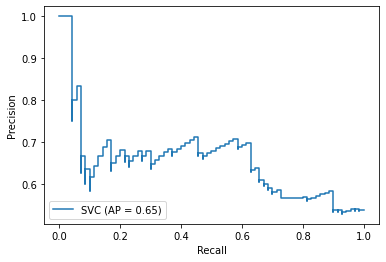

In [ ]:

X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)



PR AUC: 0.492


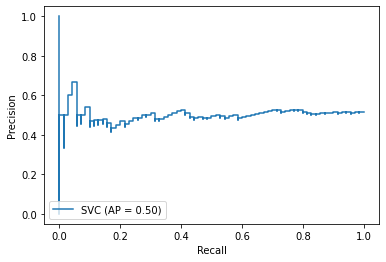

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'num_funding_rounds'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


PR AUC: 0.661


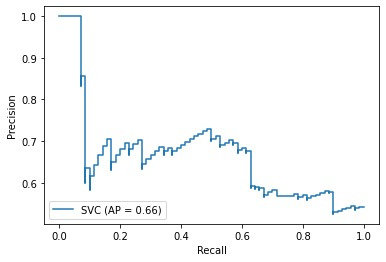

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'raised_amount_usd_mean'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


PR AUC: 0.642


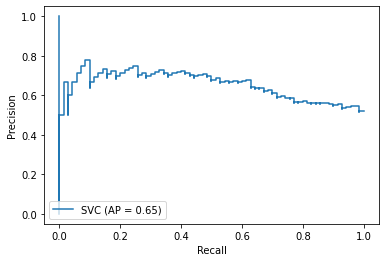

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'raised_amount_usd_std'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


PR AUC: 0.651


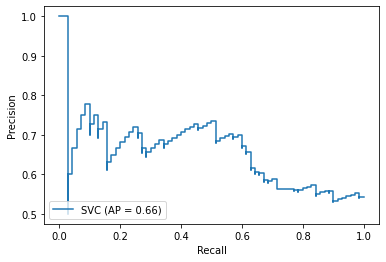

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'raised_amount_usd_median'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


PR AUC: 0.652


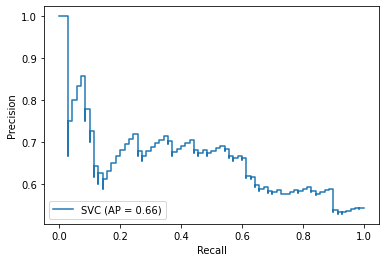

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'raised_amount_usd_max'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


PR AUC: 0.656


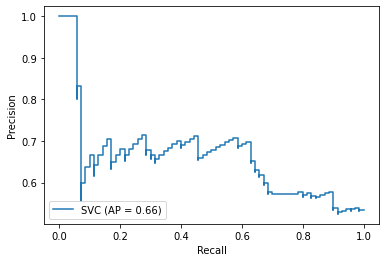

In [ ]:
X = df22_dropped.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'raised_amount_usd_min'])
y = df22_dropped.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)


In [ ]:
organizations.category_groups_list

0          Content and Publishing,Internet Services,Media...
1          Information Technology,Internet Services,Priva...
2                  Internet Services,Media and Entertainment
3          Financial Services,Lending and Investments,Sof...
4          Apps,Commerce and Shopping,Content and Publish...
                                 ...                        
1129753    Consumer Electronics,Hardware,Information Tech...
1129754                                Commerce and Shopping
1129755                                          Health Care
1129756                                                  NaN
1129757    Advertising,Commerce and Shopping,Sales and Ma...
Name: category_groups_list, Length: 1129758, dtype: object

In [ ]:
n_top_regions = 7
top_regions = df21.region.value_counts()[:n_top_regions]
def delete_unpopular_regions(row):
  global top_regions
  if not row.region in top_regions.index:
    row.region = 'Other'
  return row
df31 = df22_dropped.apply(delete_unpopular_regions, axis=1)
df31 = df31.merge(pd.get_dummies(df31.region, prefix='Region'), left_index=True, right_index=True, how='left')

df31.groupby('region')['went_public_in_n_years'].mean()


region
Beijing          0.400000
California       0.628319
Illinois         0.500000
Massachusetts    0.530303
New York         0.428571
Other            0.453901
Pennsylvania     0.533333
Texas            0.516129
Name: went_public_in_n_years, dtype: float64

PR AUC: 0.734


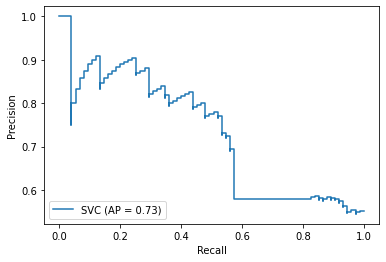

In [ ]:

X = df31.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region'])
y = df31.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)
disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)

In [ ]:
n_top_schools = 5
top_schools = degrees.institution_name.value_counts()[:n_top_regions]
def delete_unpopular_schools(row):
  global top_schools
  if not row.institution_name in top_schools.index:
    row.institution_name = 'Other'
  return row
degrees.apply(delete_unpopular_schools, axis=1)

,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,person_uuid,person_name,institution_uuid,institution_name,degree_type,subject,started_on,completed_on,is_completed
0,205fdfd1-ecac-aa43-262f-219f11755f67,MS Mass Communication @ Boston University,degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:40:03,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,1eab62d2-15d9-0db7-930f-2aa77d4688e1,Other,MS,Mass Communication,NaN,1992-01-01,True
1,1a2ac288-eb99-3318-fde5-1517bc168f51,"BA English, French @ Washington University in...",degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:39:57,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,6ae9957a-8fb4-0ab1-73fa-dd547c4d3da4,Other,BA,"English, French",NaN,1990-01-01,True
2,b978d338-7ccc-7469-5ce7-ef98c34155ad,MS Internet Technology @ University of Greenwich,degree,NaN,NaN,NaN,2008-02-19 23:40:40,2018-02-13 01:43:09,7d187b77-94f7-e6cc-6981-d7468db5968f,Sridhar Gundaiah,b5ea73f6-12a3-576d-ae9b-f4169147f974,Other,MS,Internet Technology,NaN,2006-01-01,True
3,d01cfaad-0ccc-631e-0382-1e507bf6ba04,BS Computer Science @ Northeastern University,degree,NaN,NaN,NaN,2008-02-21 01:31:01,2018-02-13 01:43:33,45e29113-19f9-c828-68d0-42ad2ef04da0,John Furrier,5f84d9fa-78fd-14b0-d335-5ac3561cdc0a,Other,BS,Computer Science,NaN,1988-01-01,True
4,16a607f5-8ab3-573e-8d09-57b3e352e1d3,BS Computer Science @ Rochester Institute of ...,degree,NaN,NaN,NaN,2008-02-21 01:31:34,2018-02-13 01:39:53,b3b4ec6b-86fe-dd6e-ec8a-e8e7e999f274,Ian Reardon,1a380593-fb9d-7f7b-ae67-784ce3ff3690,Other,BS,Computer Science,NaN,2002-01-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365744,9e713153-1cab-4b3a-b921-2e438b400535,Bachelors of Science Biology & Psychology @ T...,degree,NaN,NaN,NaN,2020-09-07 19:36:14,2020-09-07 19:36:14,53023487-4d35-4eb2-837e-43cebaa9a0db,Nadine Ngu,8fea5416-d418-ede2-3a45-43507decf319,Other,Bachelors of Science,Biology & Psychology,NaN,NaN,False
365745,37af6036-3836-4416-9f15-8c065108f45e,Masters Psychology @ Assumption College,degree,NaN,NaN,NaN,2020-09-07 19:51:14,2020-09-07 19:51:14,53023487-4d35-4eb2-837e-43cebaa9a0db,Nadine Ngu,7215a531-3451-878c-d150-e0aaee78282c,Other,Masters,Psychology,NaN,NaN,False
365746,4202c2a8-d9c0-4b84-ad57-4383b36e8e0f,MSc Computer Science / Artificial Intelligenc...,degree,NaN,NaN,NaN,2020-09-07 19:59:51,2020-09-07 19:59:51,6dbad6d0-1569-4bde-9760-a018060cadfd,Hinrik Josafat Atlason,29a141fc-2498-2695-fa94-b6aba8373780,Other,MSc,Computer Science / Artificial Intelligence,2004-09-01,2005-08-31,True
365747,ab748251-9330-4d6e-9f29-0e7b250d2373,PhD Physical Chemistry @ University of Califo...,degree,NaN,NaN,NaN,2020-09-07 20:44:50,2020-09-07 20:44:50,827a407d-313c-4e11-8351-7d38a94e2610,Wojciech Osowiecki,10f9a25b-9675-2281-486e-a52955c706df,"University of California, Berkeley",PhD,Physical Chemistry,NaN,2019-05-01,True


In [ ]:
jobs = jobs.dropna(subset=['title'])
degrees


,uuid,name,type,permalink,cb_url,rank,created_at,updated_at,person_uuid,person_name,institution_uuid,institution_name,degree_type,subject,started_on,completed_on,is_completed
0,205fdfd1-ecac-aa43-262f-219f11755f67,MS Mass Communication @ Boston University,degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:40:03,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,1eab62d2-15d9-0db7-930f-2aa77d4688e1,Boston University,MS,Mass Communication,NaN,1992-01-01,True
1,1a2ac288-eb99-3318-fde5-1517bc168f51,"BA English, French @ Washington University in...",degree,NaN,NaN,NaN,2008-02-19 17:58:31,2018-02-13 01:39:57,4897dba9-3141-ecc0-2c4b-c9d844e6440f,John Green,6ae9957a-8fb4-0ab1-73fa-dd547c4d3da4,Washington University in St. Louis,BA,"English, French",NaN,1990-01-01,True
2,b978d338-7ccc-7469-5ce7-ef98c34155ad,MS Internet Technology @ University of Greenwich,degree,NaN,NaN,NaN,2008-02-19 23:40:40,2018-02-13 01:43:09,7d187b77-94f7-e6cc-6981-d7468db5968f,Sridhar Gundaiah,b5ea73f6-12a3-576d-ae9b-f4169147f974,University of Greenwich,MS,Internet Technology,NaN,2006-01-01,True
3,d01cfaad-0ccc-631e-0382-1e507bf6ba04,BS Computer Science @ Northeastern University,degree,NaN,NaN,NaN,2008-02-21 01:31:01,2018-02-13 01:43:33,45e29113-19f9-c828-68d0-42ad2ef04da0,John Furrier,5f84d9fa-78fd-14b0-d335-5ac3561cdc0a,Northeastern University,BS,Computer Science,NaN,1988-01-01,True
4,16a607f5-8ab3-573e-8d09-57b3e352e1d3,BS Computer Science @ Rochester Institute of ...,degree,NaN,NaN,NaN,2008-02-21 01:31:34,2018-02-13 01:39:53,b3b4ec6b-86fe-dd6e-ec8a-e8e7e999f274,Ian Reardon,1a380593-fb9d-7f7b-ae67-784ce3ff3690,Rochester Institute of Technology,BS,Computer Science,NaN,2002-01-01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365744,9e713153-1cab-4b3a-b921-2e438b400535,Bachelors of Science Biology & Psychology @ T...,degree,NaN,NaN,NaN,2020-09-07 19:36:14,2020-09-07 19:36:14,53023487-4d35-4eb2-837e-43cebaa9a0db,Nadine Ngu,8fea5416-d418-ede2-3a45-43507decf319,The University of Georgia,Bachelors of Science,Biology & Psychology,NaN,NaN,False
365745,37af6036-3836-4416-9f15-8c065108f45e,Masters Psychology @ Assumption College,degree,NaN,NaN,NaN,2020-09-07 19:51:14,2020-09-07 19:51:14,53023487-4d35-4eb2-837e-43cebaa9a0db,Nadine Ngu,7215a531-3451-878c-d150-e0aaee78282c,Assumption College,Masters,Psychology,NaN,NaN,False
365746,4202c2a8-d9c0-4b84-ad57-4383b36e8e0f,MSc Computer Science / Artificial Intelligenc...,degree,NaN,NaN,NaN,2020-09-07 19:59:51,2020-09-07 19:59:51,6dbad6d0-1569-4bde-9760-a018060cadfd,Hinrik Josafat Atlason,29a141fc-2498-2695-fa94-b6aba8373780,University of Essex,MSc,Computer Science / Artificial Intelligence,2004-09-01,2005-08-31,True
365747,ab748251-9330-4d6e-9f29-0e7b250d2373,PhD Physical Chemistry @ University of Califo...,degree,NaN,NaN,NaN,2020-09-07 20:44:50,2020-09-07 20:44:50,827a407d-313c-4e11-8351-7d38a94e2610,Wojciech Osowiecki,10f9a25b-9675-2281-486e-a52955c706df,"University of California, Berkeley",PhD,Physical Chemistry,NaN,2019-05-01,True


In [ ]:
#people.featured_job_title.value_counts()
def add_founder(row):
  a = jobs[jobs.org_uuid == row.org_uuid] 
  a = a[a.title.isin(jobs[jobs.title.str.contains('Founder')].title.unique())]  
  if a.shape[0] == 0:
    return 'No info'
  else:
    a.started_on = pd.to_datetime(a.started_on)
    a.sort_values(by=['started_on'])
    b = a.iloc[0]
    c = degrees[degrees.person_uuid == b.person_uuid].institution_name

    if c.shape[0] > 1:
      return str(c.iloc[0])
    elif c.shape[0] == 1:
      return str(c)
    else:
      return 'No info'  
df32 = df31.apply(add_founder, axis=1)


In [ ]:
df32 = pd.DataFrame(df32)

In [ ]:
  df31 = df31.merge(df32, left_index=True, right_index=True, how='left')

#Тезисно: 


1.   

2.  На сбалансированной выборке категориальные фичи не дают прироста

3.  Попробовал брать другую кат. фичу -- образование не CEO, а Founder(должностей со словом Founder очень много, брал те, в которых оно содержится как подстрока). Не для каждой компании есть информация о Founder, ровно как и о первом CEO(видимо только +- актуальная по времени информация)

4.  Распределение успешных компаний по образованию последнего CEO совпадает с распределением компаний в принципе по образованию => влияние образования слабое 

5. Подтянул данные с финансовых отчетностей (Второй датасет). Информация есть только за последние несколько лет соответственно нам не подходит.

6. Следующие шаги, которые я вижу -- Посмотреть данные по инвесторам, построить граф, запустить gnn, посмотреть что будет




In [ ]:
#df31 = df31.drop(columns='founder_education')

In [ ]:
df31.rename(columns={0:'founder_education'}, inplace=True)

In [ ]:
df31

In [ ]:
n_top_unis = 6
top_unis = df31.founder_education.value_counts()[:n_top_unis]
def delete_unpopular_unis(row):
  global top_unis
  if not row.founder_education in top_unis.index:
    row.founder_education = 'Other'
  return row
df33 = df31.apply(delete_unpopular_unis, axis=1)
df33.founder_education.value_counts()

In [ ]:
df33 = df33.merge(pd.get_dummies(df33.founder_education, prefix='edu'), left_index=True, right_index=True, how='left')


In [ ]:
x = list(df33.groupby('region')['went_public_in_n_years'].mean().sort_values().index)


x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, list(df33.groupby('region')['went_public_in_n_years'].mean().sort_values()))
plt.xlabel("Percentage of successful companies")
plt.ylabel("Region of company")
plt.yticks(x_pos, x)


plt.show()

In [ ]:
df33

In [ ]:

X = df33.drop(columns=['org_uuid', 'went_public_on', 'valuation_price_usd', 'founded_on', 'went_public_in_n_years', 'region', 'founder_education'])
y = df33.went_public_in_n_years.astype(int)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

scaler = StandardScaler()
X_st = scaler.fit_transform(X_train)
X_st_test = scaler.fit_transform(X_test)

svc_rbf=SVC(kernel='rbf', C=2, gamma=2, class_weight='balanced', random_state=0, probability=True)
svc_rbf.fit(X_st, y_train)
predictions_rbf=svc_rbf.predict(X_st_test)

yhat = svc_rbf.predict_proba(X_st_test)
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)
disp = plot_precision_recall_curve(svc_rbf, X_st_test, y_test)

In [ ]:
x = list(df33.founder_education.value_counts().sort_values().index)


x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, list(df33.founder_education.value_counts().sort_values()))
plt.xlabel("Number ofcompanies")
plt.ylabel("Founder's almamater")
plt.yticks(x_pos, x)


plt.show()

In [ ]:
df33.groupby('founder_education')['went_public_in_n_years'].mean()

In [ ]:
x = list(df33.groupby('founder_education')['went_public_in_n_years'].mean().sort_values().index)



x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, list(df33.groupby('founder_education')['went_public_in_n_years'].mean().sort_values()))
plt.xlabel("Percentage of successful companies")
plt.ylabel("Founder's almamater")
plt.yticks(x_pos, x)


plt.show()

In [ ]:
list(df33.groupby('founder_education')['went_public_in_n_years'].mean().index)

Todo:
1) Построить ROC кривые
2) Построить PR кривые на одном графике.
3) Приводим ROC-AUC, PR-AUC, F1 score, Accuracy.
4) Гистограммы по возрастанию.
5) Доверительные интервалы на гистограммах.
6) Other на гистограммах другим цветом.
7) Studet test, что для каждого региона процент успешных компаний выше среднего по выборке.
8) Написать Сергею Иванову.
9) lgbm feature importance
10) Посмотреть размеры выборки, для которой доступна каждая доступная фича.
11) GNN!!!
